# Lecture 9: Predictive Modeling: Regression

## Contents

- [Imports](#section1)
- [Introduction to statistical learning](#section2)
    - [Supervised and unsupervised learning](#subsection2.1)
    - [Regression versus classification](#subsection2.2)
- [Regression for predictive modeling](#section3)
    - [Generic expression](#subsection3.1)
    - [Bias-variance trade-off](#subsection3.2)
    - [Model selection](#subsection3.3)
    - [Implementation via <code>scikit-learn</code>](#subsection3.4)
- [Regularized linear models](#section4)
- [Dimension reduction](#section5)
    - [Motivation: curse of dimensionality](#subsection5.1)
    - [Principal component analysis](#subsection5.2)
- [Case studies](#section6)
    - [Case study 1: Baseball players' data](#subsection6.1)

## Imports <a id="section1"></a>

In [1]:
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 10, 
              "display.max_rows", 7)                    # Diaply configuration of Pandas data frame

from sklearn.linear_model import LinearRegression       # Import the linear regression model
from sklearn.linear_model import Ridge                  # Import the ridge regression model
from sklearn.linear_model import Lasso                  # Import the LASSO model
from sklearn.model_selection import train_test_split    # Import the train/test splitting tool
from sklearn.model_selection import cross_val_score     # Import the cross-valication tool
from sklearn.model_selection import GridSearchCV        # Import the grid search tool
from sklearn.preprocessing import PolynomialFeatures    # Import the tool for polynomial features
from sklearn.preprocessing import StandardScaler        # Import standardization tool
from sklearn.pipeline import Pipeline                   # Import the pipeline)
from sklearn.decomposition import PCA                   # Import the PCA tool

## Regression for predictive modeling <a id="section3"></a>

### Generic expressions <a id="subsection3.1"></a>
Similar to the explanatory model discussed in the previous lecture, the relation between a quantitative predicted variable $y$ and $p$ predictor variables, denoted by $\pmb{x}=\left(x_1, x_2, ..., x_p\right)$, can be generalized as

$$
y = f(\pmb{x}) + u,
$$

where $f$ is some fixed but unknown function of predictors $\pmb{x}$ and $u$ is a random error term that is independent of $\pmb{x}$ and has mean zero. In the context of predictive modeling, we are interested in predicting $\hat{y}$ using

$$
\hat{y} = \hat{f}(\pmb{x}),
$$

where $\hat{f}$ represents our estimate for the unknown function $f$, which is typically obtained using a training dataset $\left\{(\pmb{x}_1, y_1), (\pmb{x}_2, y_2), ..., (\pmb{x}_p, y_p)\right\}$. In the regression setting, a commonly-used approach for identifying $\hat{f}$ is to minimize the **mean squared error (MSE)**, given by

$$
\text{MSE} = \frac{1}{n}\sum\limits_{i=1}^n\left(y_i - \hat{f}(\pmb{x})\right)^2.
$$

### Bias-variance trade-off <a id="subsection3.2"></a>权衡偏差与方差

The MSE term computed above using the training dataset is refer to as the **training MSE**. In assessing the performance of the model, we are more interested in the prediction accuracy as $\hat{f}$ is applied to previously unseen test observations rather than the training dataset, so models with the lowest **test MSE** is preferred. Let $\left(\pmb{x}_0, y_0\right)$ be a test observation, the expected squared error term can be written as 这个是population regression function (PRF),

$$
\mathbb{E}\left(y_0 - \hat{f}(\pmb{x}_0)\right)^2 = \mathbb{E}\left(f(\pmb{x}_0)+u - \hat{f}(\pmb{x}_0)\right)^2 = \mathbb{E}\left(f(\pmb{x}_0) - \hat{f}(\pmb{x}_0)\right)^2 + \text{Var}(u). 
$$

Note that in the second term of the expression above, the error term $u$ is independent from the model, so no matter how well we specify the model, its variance cannot be reduced, thus $\text{Var}(u)$ is called the **irreducible error**.不可约误差The other term $\mathbb{E}\left(f(\pmb{x}_0) - \hat{f}(\pmb{x}_0)\right)^2$ represents the derivation of the prediction $\hat{f}(\pmb{x}_0)$ from the true value of $f(\pmb{x}_0)$ . This error term can be reduced as the accuracy of the predictive model improves, so it is call the **reducible error**.

The reducible error term $\mathbb{E}\left(f(\pmb{x}_0) - \hat{f}(\pmb{x}_0)\right)^2$ can be further rewritten as 

$$
\begin{align}
\mathbb{E}\left(f(\pmb{x}_0) - \hat{f}(\pmb{x}_0)\right)^2 &= \mathbb{E}\left(f(\pmb{x}_0) - \mathbb{E}\left(\hat{f}(\pmb{x}_0)\right) + \mathbb{E}\left(\hat{f}(\pmb{x}_0)\right) - \hat{f}(\pmb{x}_0) \right)^2 \\
&=\left(f(\pmb{x}_0) - \mathbb{E}\left(\hat{f}(\pmb{x}_0)\right)\right)^2 + \text{Var}\left(\hat{f}(\pmb{x}_0)\right).
\end{align}
$$

The overall squared error is thus

$$
\mathbb{E}\left(y_0 - \hat{f}(\pmb{x}_0)\right)^2 = \left(f(\pmb{x}_0) - \mathbb{E}\left(\hat{f}(\pmb{x}_0)\right)\right)^2 + \text{Var}\left(\hat{f}(\pmb{x}_0)\right) + \text{Var}(u),
$$

where
- The first term represents the expected squared **bias** of $\hat{f}(\pmb{x}_0)$.bias的平方
- The second term measures the **variance** of $\hat{f}(\pmb{x}_0)$.方差
- The last term is the **irreducible error** $\text{Var}(u)$.不可约误差

The equation above suggests that desired prediction performance may be achieved with proper trade-off between the bias and the variance of $\hat{f}(\pmb{x}_0)$ such that the total **reducible error** is minimized. That is why in the previous lecture, we mentioned:

> *...predictive modeling seeks to minimize the combination of bias and estimation variance, occasionally sacrificing theoretical accuracy for improved empirical precision* - [To Explain or to Predict](https://www.stat.berkeley.edu/~aldous/157/Papers/shmueli.pdf)

<div class="alert alert-block alert-success">
<b>Example 1:</b>  
Use a training set with 30 observations generated from a mysterious function to train a polynomial regression model with <b>k</b> polynomial terms. The polynomial regression model is then used to give predictions for a test set. Explore the influence of the parameter <b>k</b> on the performance of the polynomial regression model.
</div>

You may visit the website [Programming for Business Analytics](https://share.streamlit.io/xiongpengnus/learn_dao/main/web.py) to observe the influence of different $k$ values on the model performance. We first look at two extreme cases where $k=1$ and $k=25$. The following figure shows how the polynomial function $\hat{f}$ fits the training and test data.

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/under_over_fitting.png?raw=true" width=700>


Our observations of the two polynomial regression models are summarized in the table below.

| | Polynomial degree $k=1$ | Polynomial degree $k=25$ |
|:-----|:---------|:------------|
|**Flexibility of function $\hat{f}$** | Low | High |
|**Training MSE** | High | Low |
|**Test MSE** | High | High |
|**Bias/variance** | High bias but low variance | Low bias but high variance |

For models with small values of $k$, the polynomial function $\hat{f}$ is relatively inflexible and may be unable to capture the nonlinear trend of both the training and test data, leading to high training and test MSEs. Such cases are referred to as **under-fitting**. As the $k$ value increase, the training MSE decreases monotonically, and for very large $k$ values, the training MSE drops to nearly zero as the fitted response pass almost all train data points. However, the test MSE may drastically increase as the fitted curve shows wide oscillations. Such cases are referred to as **over-fitting**. 

Another interpretation of under-fitting and over-fitting is the trade-off between bias and variance. You may notice that the under-fitting models have larger biases but smaller variances, while the over-fitting models have smaller biases but larger variances.

As shown by the following figure, the lowest test MSE (as our foremost concern) is achieved as a proper value of $k$ is selected.

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/k_mse.png?raw=true" width=350>

Take $k=5$ for example, it can be seen that this polynomial function has an appropriate level of flexibility such that it is able to follow the trend of the training/test data without having huge oscillations. It is also capable of keeping both the bias and variance of the estimates low at the same time. 

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/fit_k_5.png?raw=true" width=350>

Additional observations of the experiments above:
- In over-fitting cases, the magnitudes of model coefficients are extremely large.
- Models commonly do not perform well as the test data approach the borders.

### Model selection <a id="subsection3.3"></a>

Our observations above show that it is essential to determine the proper level of flexibility complexity of the model, so that we could avoid under-fitting or over-fitting.

> *If data is plentiful, then one approach is simply to use some of the available data to train a range of models, or a given model with a range of values for its complexity parameters, and then to compare them on
independent data, sometimes called a validation set, and select the one having the best predictive performance. If the model design is iterated many times using a limited size data set, then some over-fitting to the validation data can occur and so it may be necessary to keep aside a third test set on which the performance of the selected model is finally evaluated.* 

> *In many applications, however, the supply of data for training and testing will be limited, and in order to build good models, we wish to use as much of the available data as possible for training. However, if the validation set is small, it will give a relatively noisy estimate of predictive performance. One solution to this dilemma is to use **cross-validation**, which is illustrated in the following figure. This allows a proportion
$(S −1)/S$ of the available data to be used for training while making use of all of the data to assess performance. When data is particularly scarce, it may be appropriate to consider the case S = N, where N is the total number of data points, which gives the **leave-one-out technique**.* - [Pattern Recognition and Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/cross_validation.png?raw=true" width=600>

### Implementation via <code>scikit-learn</code> <a id="subsection3.4"></a>

<code>scikit-learn</code> is an open source package, it is constantly being developed and improved, and it
has a very active user community. It contains a number of state-of-the-art machine learning algorithms, as well as comprehensive [documentation](https://scikit-learn.org/stable/index.html) about each algorithm. <code>scikit-learn</code> is a very popular tool, and the most prominent Python library for machine learning. It is widely used in industry and academia, and a wealth of tutorials and code snippets are available online. 

<div class="alert alert-block alert-success">
<b>Example 2:</b>  
    The file "polydata.csv" provides a dataset with 40 observations of the dependent variable <b>y</b> and independent variable <b>x</b>. Use the tools provided in the <b>scikit-learn</b> package to:
<li>Create new columns for $k$ polynomial terms of the predictor variable <b>x</b></li>
<li>Split the overall dataset into a training set and a test set.</li>
<li>Train the $k$th degree polynomial regression model based on the training set.</li>
<li>Retrieve the parameters of the fitted model.</li>
<li>Find the $R^2$ values for the training and test sets.
</div>

In [12]:
data = pd.read_csv('polydata.csv')
data.head(5)

,y,x
0,4.903104,0.082443
1,2.555793,0.437323
2,9.459503,0.943338
3,10.881539,0.600545
4,12.071988,0.979821


In [ ]:
data['polynomial']

#### Creating polynomial terms as the features
The <code>scikit-learn</code> package provides powerful tools for each step of implementing the regression model. Please note that when importing the package, the name of the package is written as <code>sklearn</code>. 
 
It can be seen that the data frame above only provides the data for the predicted variable <code>y</code> and predictor variable <code>x</code>, so the first step of implementing the polynomial regression model is to create polynomial terms of <code>x</code>.

In [13]:
k = 4
poly = PolynomialFeatures(k, include_bias=True)
columns = poly.fit_transform(data[['x']])
pd.DataFrame(columns).head(5)

,0,1,2,3,4
0,1.0,0.082443,0.006797,0.000560,0.000046
1,1.0,0.437323,0.191251,0.083638,0.036577
2,1.0,0.943338,0.889886,0.839463,0.791897
3,1.0,0.600545,0.360655,0.216590,0.130072
4,1.0,0.979821,0.960050,0.940677,0.921695


In [39]:
k = 4                                               # Degree of the polynomial function
poly = PolynomialFeatures(k, include_bias=False)    # Create a kth-degree polynomial transformation
x_ft = poly.fit_transform(data[['x']])              # Create columns of x**1, x**2, ...., x**k

In the code above, the function <code>PolynomialFeatures()</code> imported from the package <code>sklearn.preprocessing</code> is used to create an object for the kth-degree polynomial transformation. We then call the <code>fit_transform()</code> method of the object to transform the column <code>x</code> into its polynomial terms. 

#### Train/test split
Based on the dependent variable <code>y</code> and the polynomial features <code>x_poly</code>, the training set and the test set can be created by a function called <code>train_test_split()</code>, which is imported from the <code>sklearn.model_selection</code> package. 

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_ft, data['y'], test_size=0.25)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_ft, data['y'], test_size=0.25)  

The first two positional variables are the predictor and predicted variables, while the keyword argument <code>test_size</code> specifies the proportion of observations for the test set. In the default setting, the dataset will be randomly shuffled before splitting the dataset, thus the results could be different in each run.

#### Train the regression model
The next step is to train the regression model, which can be done by the function <code>LinearRegression()</code> imported from the package <code>sklearn.linear_model</code>.

In [20]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()       # 这里和上面的Polynomial很像 都是先建object 再带入
regr.fit(x_train, y_train)

LinearRegression()

In [26]:
np.round(regr.intercept_, 2)

1.42

In [27]:
regr.coef_

array([  73.68215634, -366.81818142,  670.95772831, -371.98007403])

In [22]:
regr = LinearRegression()       # Create an linear regerssion object
regr.fit(x_train, y_train)      # Train the model with the training data set

LinearRegression()

In [29]:
regr.score(x_test, y_test)

0.5979013376227942

The parameters of the fitted model can be retrieved by the attributes <code>intercept_</code> and <code>coef_</code> of the model object.

In [23]:
print('Intercept is {}'.format(np.round(regr.intercept_, 3)))
print('Slope parameters are {}'.format(np.round(regr.coef_, 3)))

Intercept is 1.42
Slope parameters are [  73.682 -366.818  670.958 -371.98 ]


#### Performance of the trained model

Performance of the model is assessed by calculating the $R^2$ using the <code>score()</code> method of the regression model object. 

In [7]:
r2_training = regr.score(x_train, y_train)
r2_test = regr.score(x_test, y_test)

print('Training R-squared value: {0:0.4f}'.format(r2_training))
print('Test R-squared value: {0:0.4f}'.format(r2_test))

Training R-squared value: 0.8818
Test R-squared value: 0.7377


Recalling that the $R^2$ value is written as
$$
R^2 = 1 - \frac{\sum_{i=1}^n\left(y_i - \hat{y}_i\right)^2}{\sum_{i=1}^n\left(y_i - \bar{y}_i\right)^2} = 1 - \frac{\text{MSE}}{\frac{1}{n}\sum_{i=1}^n\left(y_i - \bar{y}_i\right)^2},
$$
where the numerator of the second term is MSE, and the denominator is a constant independent from the model. According to this expression, we can conclude that $R^2=0$ if our prediction is only as good as the average value $\bar{y}$, and $R^2$ approaches one if the MSE is reduced to zero.

#### Use the trained model for prediction

The trained model can be then used to predict values of $y$ for previously unseen predictor variable $x$. For example, as the predictor variable $x$ is changed from 0 to 1 (with step to be 0.01), we want to predict the corresponding $y$ values so that the curve of the fitted function can be plotted. 

In [35]:
a = np.arange(0,1.01,0.01)
x_pre = poly.fit_transform(pd.DataFrame(a))   # 再次注意.fit_transform后面必须是DataFrame
y_pre = regr.predict(x_pre)                   # 这样就求出了每一个预测的值

In [8]:
x_pred = np.arange(0, 1.01, 0.01)                       # x values between 0 and 1
x_ft_pred = poly.fit_transform(pd.DataFrame(x_pred))    # Create columns of x**1, x**2, ...., x**k
y_pred = regr.predict(x_ft_pred)                        # Predict y using polynomial terms of x

The array of $x$ values and the array of predictions of $y$ are used in the code segment below for showing the fitted values of the polynomial regression model. 

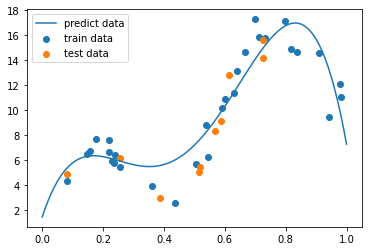

In [46]:
import matplotlib.pyplot as plt
plt.scatter(x_train[:,0], y_train, label='train data')    # 用于拟合的值 都是实际值 注意这里只取第一列 因为是x的值
plt.scatter(x_test[:,0], y_test, label='test data')       # 用于测试的值 也都是实际值
plt.plot(a, y_pre, label='predict data')                  # 用于预测的值 y是预测出来的
plt.legend()
plt.show()

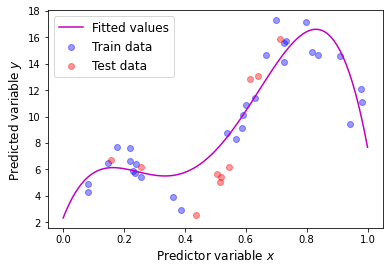

In [9]:
plt.scatter(x_train[:, 0], y_train, 
            c='b', alpha=0.4, label='Train data')
plt.scatter(x_test[:, 0], y_test, 
            c='r', alpha=0.4, label='Test data')
plt.plot(x_pred, y_pred, 
         color='m', label='Fitted values')

plt.legend(fontsize=12)
plt.xlabel('Predictor variable $x$', fontsize=12)
plt.ylabel('Predicted variable $y$', fontsize=12)
plt.show()

#### Cross-validation and grid search
The cross-validation technique can be directly implemented by the function <code>cross_val_score()</code> imported from the <code>sklearn.model_selection</code> package. We just need to specify the model object, predictor and predicted variables, and the number of folds for the cross-validation, via the function arguments. The output is an array of $R^2$ values for each fold. Some other measures given in [this link](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) can also be used as the performance indicator. They are enabled by specifying the argument <code>scoring</code> of the function <code>cross_val_score()</code>.

In [48]:
k = 5
poly = PolynomialFeatures(k, include_bias=False)
x = poly.fit_transform(data[['x']])
regr = LinearRegression()                        # 需要预先设立回归的形式

cross_val_score(regr, x, data['y'], cv=4)        # 并不需要特别有train test分离那一步 在这里直接做了


array([0.89938951, 0.92439518, 0.9663815 , 0.91419212])

In [10]:
k = 5
poly = PolynomialFeatures(k, include_bias=False)    # Create a polynomial transformation
x_ft = poly.fit_transform(data[['x']])              # Create columns of x**0, x**1, ...., x**k
regr = LinearRegression()                           # Create an linear regerssion object

cross_val_score(regr, x_ft, data['y'], cv=4)        # Perform cross-validation with 4 folds

array([0.89938951, 0.92439518, 0.9663815 , 0.91419212])

The code above can be further simplified by using <code>sklearn</code> pipelines. The pipeline summarizes all steps of data preprocessing and and learning method in a single function, as demonstrated below.

In [11]:
k = 5
steps = [
    ('poly', PolynomialFeatures(k, include_bias=False)),    # Step 1: polynormial transformation
    ('lr', LinearRegression())                              # Step 2: linear regression
]                            
pipe = Pipeline(steps)                                      # Create a pipeline
cross_val_score(pipe, data[['x']], data['y'], cv=4)         # Perform cross-validation

array([0.89938951, 0.92439518, 0.9663815 , 0.91419212])

Please note that:
1. Intermediate steps of the pipeline must be "transforms", that is, they must implement fit and transform methods. The final estimator only needs to implement fit. 
2. The "x" data must be given as a two-dimensional data structure, such as a two-dimensional array or a data frame. 

The value <code>k</code> is referred to as a **hyperparameter**, which is not affected by the learning algorithm itself; it must be set prior to training and remains constant during training. The <code>sklearn</code> package also provides convenient tools to tune hyperparameters, such as by using the function <code>GridSearchCV()</code>.

In [12]:
param = {'poly__degree': np.arange(1, 16)}                  # Vary the parameter degree of poly
steps = [
    ('poly', PolynomialFeatures(include_bias=False)),       # Step 1: polynormial transformation
    ('lr', LinearRegression())                              # Step 2: linear regression
]                        

pipe = Pipeline(steps)                                      # Create a pipline
search = GridSearchCV(pipe, param, cv=4)                    # Create a grid search for the best parameter  
search.fit(data[['x']], data['y'])                          # Fit the model with the x and y data

k_best = search.best_params_['poly__degree']                  
print('Best parameter: {0}'.format(k_best))                 # Best paramter
print('Best score: {0:0.3f}'.format(search.best_score_))    # R-squared value for the best parameter

Best parameter: 5
Best score: 0.926


In the code segment above, possible values of the hyperparameter is specified by the first line, the string <code>'poly__degree'</code> suggests that the parameter is the attribute <code>degree</code> of the object named <code>'poly'</code>. 

The `search` object has a `dict` type attribute called `cv_results_`, which provides useful information on results of running the cross-validation. The code cell below provides an example of the average test scores under different hyperparameter values. 

In [13]:
search.cv_results_['mean_test_score']

array([  0.53389763,   0.51298326,   0.66893669,   0.84719287,
         0.92608958,   0.91787972,   0.91146481,   0.90729571,
         0.9103041 ,   0.9250095 ,   0.84647308,   0.42031482,
        -1.60123746, -23.24696963, -11.09599076])

## Regularized linear models <a id="section4"></a>

In the previous section we saw that when over-fitting occurs, the magnitudes of model parameters become extremely large, thus causing the wide oscillations behaviors. One technique that is often used to control the over-fitting phenomenon in such cases is that of **regularization**, which involves adding a penalty term to the SSR objective function in order to discourage the parameters from reaching large values. This is why these methods are sometimes called the **shrinkage methods**. According to the formula of the penalty term, we have two types of the regularized models: ridge regression and least absolute shrinkage and selection operator (LASSO).
\begin{align}
\text{Ridge regression: }& \min~\sum\limits_{i=1}^n \left(y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} ... \beta_k x_{ik} \right)^2 + \alpha\sum\limits_{j=1}^k \beta_j^2 \\
\text{LASSO: }& \min~\frac{1}{2 n}\sum\limits_{i=1}^n \left(y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} ... \beta_k x_{ik} \right)^2 + \alpha\sum\limits_{j=1}^k |\beta_j|
\end{align}

In [3]:
data = pd.read_csv('credit.csv')
data.head(5)

,Income,Limit,Rating,Cards,Age,...,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,...,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,...,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,...,Male,No,No,Asian,580
3,148.924,9504,681,3,36,...,Female,No,No,Asian,964
4,55.882,4897,357,2,68,...,Male,No,Yes,Caucasian,331


In [21]:
pd.get_dummies(data, drop_first=True)

,Income,Limit,Rating,Cards,Age,...,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,...,0,0,1,0,1
1,106.025,6645,483,3,82,...,1,1,1,1,0
2,104.593,7075,514,4,71,...,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
397,57.872,4171,321,5,67,...,1,0,1,0,1
398,37.728,2525,192,1,44,...,0,0,1,0,1
399,18.701,5524,415,5,64,...,1,0,0,1,0


In [19]:
data_num.drop(columns='Balance')

,Income,Limit,Rating,Cards,Age,...,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,...,0,0,1,0,1
1,106.025,6645,483,3,82,...,1,1,1,1,0
2,104.593,7075,514,4,71,...,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
397,57.872,4171,321,5,67,...,1,0,1,0,1
398,37.728,2525,192,1,44,...,0,0,1,0,1
399,18.701,5524,415,5,64,...,1,0,0,1,0


The objective function of the ridge regression model trades off two different criteria. As with least squares, ridge regression seeks coefficient estimates that fit the data well, by making the RSS
small. However, the second term, $\alpha\sum_{j=1}^k\beta_j^2$, called a **shrinkage penalty**, is small when $\beta_1$, ..., $\beta_k$ are close to zero, and so it has the effect of shrinking penalty
the estimates of $\beta_j$ towards zero. The hyperparameter $\alpha$ serves to control the relative impact of these two terms on the regression coefficient estimates. When $\alpha = 0$, the penalty term has no effect, and ridge regression will produce the least squares estimates. However, as $\alpha\rightarrow \infty$, the impact of
the shrinkage penalty grows, and the ridge regression coefficient estimates will approach zero. You may find this diagram from the reference book [An Introduction to Statistical Learning-with Applications in R](https://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf) on page 216. 

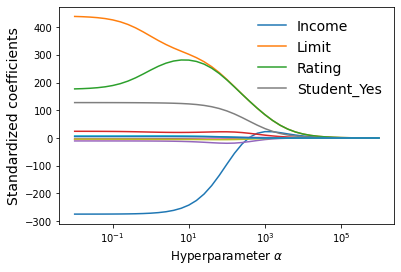

In [16]:
alphas = 10**np.arange(-2, 6.2, 0.2)
slopes = []
x_data = data_num.drop(columns='Balance')
y_data = data_num['Balance']
for alpha in alphas:
    steps = [('scaler', StandardScaler()),
             ('ridge', Ridge(alpha))]
    pipe = Pipeline(steps) 
    pipe.fit(x_data, y_data)
    slopes.append(pipe._final_estimator.coef_)  # Coefficients of 

slopes = np.array(slopes)
for i in range(len(x_data.columns)):
    label = x_data.columns[i]
    if label in ['Income', 'Limit', 'Rating', 'Student_Yes']:
        plt.plot(alphas, slopes[:, i], 
                 label=x_data.columns[i])
    else:
        plt.plot(alphas, slopes[:, i])

plt.legend(fontsize=14, frameon=False)
plt.xlabel(r'Hyperparameter $\alpha$', fontsize=12)
plt.ylabel('Standardized coefficients', fontsize=14)
plt.xscale('log')
plt.show()

Unlike least squares, which generates only one set of coefficient estimates, ridge regression will produce a different set of coefficient estimates for each value of $\alpha$. Selecting a good value for $\alpha$ is critical, and it can be determined by the grid search approach.

In [15]:
param = {'ridge__alpha': 10**np.arange(-5, 4.5, 0.5)}           # Vary the alpha parameter
steps = [
    ('scaler', StandardScaler()),                               # Step 1: Standardized scaler
    ('ridge', Ridge()),                                         # Step 2: ridge regression
]

pipe = Pipeline(steps)                                          # Create a pipline
search = GridSearchCV(pipe, param, cv=4)                        # Create a grid search for the best parameter 
x, y = data_num.drop(columns='Balance'), data_num['Balance']    # Predictor and predicted variables
search.fit(x, y)                                                # Fit the model with the x and y data

alpha_best = search.best_params_['ridge__alpha']                  
print('Best parameter: {0:0.5f}'.format(alpha_best))            # Best paramter
print('Best score: {0:0.3f}'.format(search.best_score_))        # R-squared value for the best parameter

Best parameter: 0.03162
Best score: 0.951


As with ridge regression, the lasso shrinks the coefficient estimates towards zero. However, in the case of the lasso, the different penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\alpha$ is sufficiently large. Hence, much like best subset selection, the lasso performs variable selection. As a result, models generated from the lasso are generally much easier to interpret than those produced by ridge regression. We say that the lasso yields sparse models—that is, models that involve only a subset of the variables. The same figure can be found on page 220 of the reference book [An Introduction to Statistical Learning-with Applications in R](https://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf).

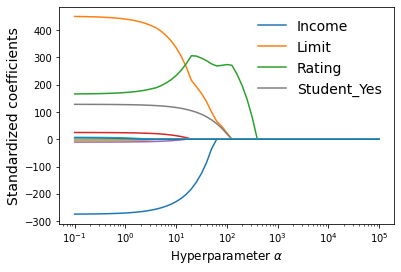

In [18]:
alphas = 10**np.arange(-1, 5.1, 0.1)
slopes = []
x_data = data_num.drop(columns='Balance')
y_data = data_num['Balance']
for alpha in alphas:
    steps = [('scaler', StandardScaler()),
             ('lasso', Lasso(alpha, max_iter=1e6))]
    pipe = Pipeline(steps) 
    pipe.fit(x_data, y_data)
    slopes.append(pipe._final_estimator.coef_)

slopes = np.array(slopes)
for i in range(len(x_data.columns)):
    label = x_data.columns[i]
    if label in ['Income', 'Limit', 'Rating', 'Student_Yes']:
        plt.plot(alphas, slopes[:, i], 
                 label=x_data.columns[i])
    else:
        plt.plot(alphas, slopes[:, i])

plt.legend(fontsize=14, frameon=False)
plt.xlabel(r'Hyperparameter $\alpha$', fontsize=12)
plt.ylabel('Standardized coefficients', fontsize=14)
plt.xscale('log')
plt.show()

As in ridge regression, selecting a good value of $\alpha$ for the lasso model is critical, and we can also use grid search method as follows.

In [19]:
param = {'lasso__alpha': 10**np.arange(-5, 5.1, 0.1)}           # Vary the alpha parameter
steps = [
    ('scaler', StandardScaler()),                               # Step 1: Standardized scaler
    ('lasso', Lasso(max_iter=1e5))                              # Step 2: LASSO
]                        

pipe = Pipeline(steps)                                          # Create a pipline
search = GridSearchCV(pipe, param, cv=4)                        # Create a grid search for the best parameter 
x, y = data_num.drop(columns='Balance'), data_num['Balance']    # Predictor and predicted variables
search.fit(x, y)                                                # Fit the model with the x and y data

alpha_best = search.best_params_['lasso__alpha']                  
print('Best parameter: {0}'.format(np.round(alpha_best, 3)))    # Best paramter
print('Best score: {0:0.3f}'.format(search.best_score_))        # R-squared value for the best parameter

Best parameter: 0.501
Best score: 0.951


In [23]:
data_num.head(5)

,Income,Limit,Rating,Cards,Age,...,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,...,0,0,1,0,1
1,106.025,6645,483,3,82,...,1,1,1,1,0
2,104.593,7075,514,4,71,...,0,0,0,1,0
3,148.924,9504,681,3,36,...,1,0,0,1,0
4,55.882,4897,357,2,68,...,0,0,1,0,1


## Dimension reduction <a id="section5"></a>

Please note that the term "dimension" used in this section is different from the same word we used in discussing NumPy arrays. Here the dimension is the number of predictor variables or features, and how they can be visualized. Take a case with two predictors, for example, the values of these two variables can be visualized by a two-dimensional diagram. While for three variables, they can be visualized in a three-dimensional space. As for cases with more than three dimensions, there is no easy way to visualize them by simply increasing dimensions.

### Motivation: curse of dimensionality <a id="subsection5.1"></a>

> *Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution, as we will see. This problem is often referred to as the **curse of dimensionality**.* - [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.lpsm.paris/pageperso/has/source/Hand-on-ML.pdf)

The curse of dimensionality is illustrated by interactive data visualizations provided on [Programming for Business Analytics](https://share.streamlit.io/xiongpengnus/learn_dao/main/web.py):
- All data points tend to approach the borders as the data dimensions increase;
- Test data points are farther away from the training dataset as data dimensions increase.

### Principal component analysis <a id="subsection5.2"></a>

**Principal components analysis (PCA)** is an **unsupervised learning** approach for deriving a low-dimensional set of features from a large set of variables. These features or so called **principal components** are linear combinations of the original independent variables, and the variances along the selected dimensions are maximized. 

In order to demonstrate how the PCA is applied to reduce data dimensions, we consider the dataset "USArrests.csv", where the crime statistics per 100,1000 residents in 50 states of USA are provided. 

In [28]:
usa = pd.read_csv('USArrests.csv')
usa.head(5)

,States,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


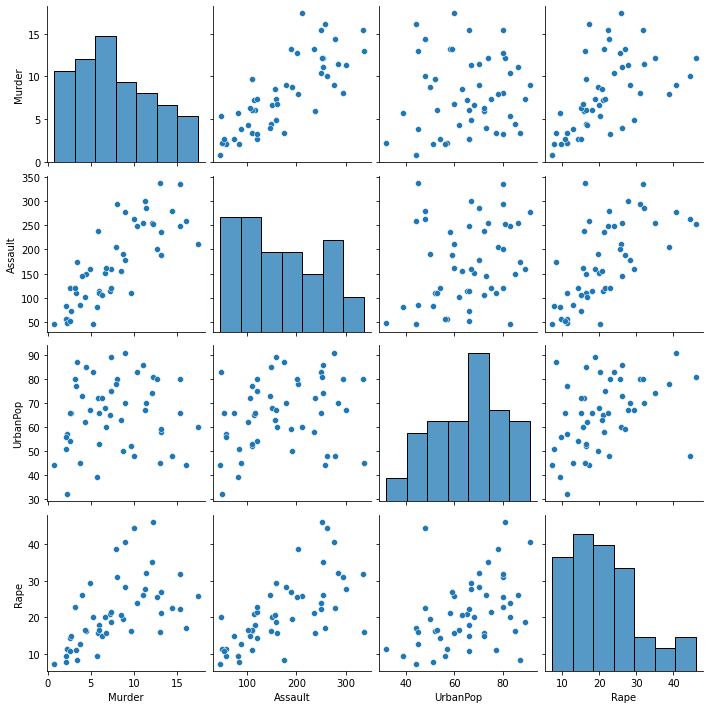

In [25]:
sns.pairplot(usa)

The correlation table below shows that variables `Murder`, `Assault`, `UrbanPop`, and `Rape` are highly correlated, and such relations can be verified by the subsequent pair plots. 

In [21]:
usa.corr()

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


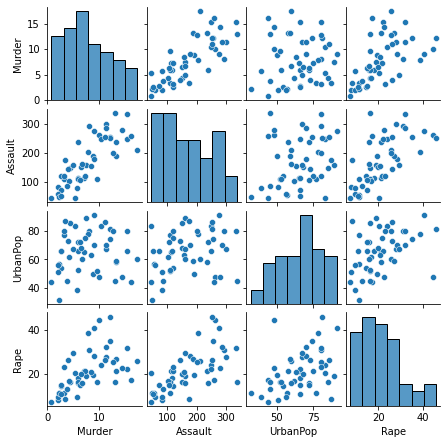

In [22]:
pplt = sns.pairplot(usa)                # Pair plots of all quantitative variables
pplt.fig.set_size_inches(6,6)           # Change the figure size of the pair plots

Consider two variables `Assault` and `Murder` that are highly correlated, we may use the following steps to derive a principal component for dimension reduction. 

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/pca_reduce_one.png?raw=true" width=500>

- Subplot (a) shows the data of two selected variables `Assault` and `Murder`. The correlation between these two variables is 0.8019.
- Subplot (b) shows the standardized values of the selected variables, and displays two perpendicular components that captures the variation of these two variables.
- Subplot (c) shows that the first principal component captures most of the variation of these two variables, and the remaining variation is represented by the second principal component.
- Subplot (d) shows that as the second principal component is removed, the dimension of data is reduced while the first component preserves most of (not all) the variation information in the selected variable.

You may use the interactive data visualization provided on [Programming for Business Analytics](https://share.streamlit.io/xiongpengnus/learn_dao/main/web.py) to conduct similar experiments on other pairs of variables. 

Now let us drive two principal components from these four variables using tools provided by the the `sklearn` package. 


In [29]:
x = usa.drop(columns='States')              # All columns except 'States'
x_std = StandardScaler().fit_transform(x)   # Standardization of the variable

nc = 2                                      # Number of principal components
pca = PCA(n_components=nc)                  # Create a PCA object and specify the number of components

z = pd.DataFrame(pca.fit_transform(x_std),  # Derive the principal components using the PCA object
                 columns=['PC1', 'PC2'])    # Convert the array to a data frame
z.head(5)

,PC1,PC2
0,0.985566,1.133392
1,1.950138,1.073213
2,1.763164,-0.745957
3,-0.141420,1.119797
4,2.523980,-1.542934


In [31]:
x_std

array([[ 1.25517927,  0.79078716, -0.52619514, -0.00345116],
       [ 0.51301858,  1.11805959, -1.22406668,  2.50942392],
       [ 0.07236067,  1.49381682,  1.00912225,  1.05346626],
       [ 0.23470832,  0.23321191, -1.08449238, -0.18679398],
       [ 0.28109336,  1.2756352 ,  1.77678094,  2.08881393],
       [ 0.02597562,  0.40290872,  0.86954794,  1.88390137],
       [-1.04088037, -0.73648418,  0.79976079, -1.09272319],
       [-0.43787481,  0.81502956,  0.45082502, -0.58583422],
       [ 1.76541475,  1.99078607,  1.00912225,  1.1505301 ],
       [ 2.22926518,  0.48775713, -0.38662083,  0.49265293],
       [-0.57702994, -1.51224105,  1.21848371, -0.11129987],
       [-1.20322802, -0.61527217, -0.80534376, -0.75839217],
       [ 0.60578867,  0.94836277,  1.21848371,  0.29852525],
       [-0.13637203, -0.70012057, -0.03768506, -0.0250209 ],
       [-1.29599811, -1.39102904, -0.5959823 , -1.07115345],
       [-0.41468229, -0.67587817,  0.03210209, -0.34856705],
       [ 0.44344101, -0.

These two principal components `PC1` and `PC2` are barely correlated as shown by the correlation table below.

In [32]:
z.corr()

,PC1,PC2
PC1,1.000000e+00,2.426933e-16
PC2,2.426933e-16,1.000000e+00


Note that the principal components are linear combinations of the original variables, so they can be written as

$$
z_1 = \phi_{11} x_{\text{Murder}} + \phi_{21} x_{\text{Assault}} + \phi_{31} x_{\text{UrbanPop}} + \phi_{41}x_{\text{Rape}} \\
z_2 = \phi_{12} x_{\text{Murder}} + \phi_{22} x_{\text{Assault}} + \phi_{32} x_{\text{UrbanPop}} + \phi_{42}x_{\text{Rape}} \\
$$

where $\phi_{jk}$ are coefficients of the linear combination expression. These coefficients can be retrieved as the `components_` attribute of the `PCA` object, as shown below. The similar results can be found in Table 10.1 (page 377) of the reference book [An Introduction to Statistical Learning-with Applications in R](https://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf).

In [25]:
pd.DataFrame(pca.components_.T,         # Transpose of the components_ attribute
             columns=['PC1', 'PC2'],    # Column labels
             index=x.columns)           # Row indices

,PC1,PC2
Murder,0.535899,0.418181
Assault,0.583184,0.187986
UrbanPop,0.278191,-0.872806
Rape,0.543432,-0.167319


<div class="alert alert-block alert-success">
<b>Example 3:</b>  
    The file "Hitters.csv" provides a dataset on baseball players. Predict players' salaries using a proper linear regression model.
</div>

The code cell below prepares a dataset for predicting baseball players' salaries. Description of the dataset can be found from [here](https://rdrr.io/cran/ISLR/man/Hitters.html).

In [45]:
x = data.drop(columns='Salary')
y = data['Salary']

regr = LinearRegression()
cross_val_score(regr, x, y, cv=4).mean()

0.3467623890610856

In [42]:
hitters = pd.read_csv('Hitters.csv')
hitters = hitters.loc[hitters['Salary'].notnull()].reset_index(drop=True)
hitters_num = pd.get_dummies(hitters, drop_first=True)
hitters_num

,AtBat,Hits,HmRun,Runs,RBI,...,Errors,Salary,League_N,Division_W,NewLeague_N
0,315,81,7,24,38,...,10,475.0,1,1,1
1,479,130,18,66,72,...,14,480.0,0,1,0
2,496,141,20,65,78,...,3,500.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
260,475,126,3,61,43,...,7,385.0,0,1,0
261,573,144,9,85,60,...,12,960.0,0,0,0
262,631,170,9,77,44,...,3,1000.0,0,1,0


The following code segment implements the regression model directly where all predictor variables are considered.

In [27]:
x = hitters_num.drop(columns='Salary')
y = hitters_num['Salary']

regr = LinearRegression()                   # Linear regression model
cross_val_score(regr, x, y, cv=10).mean()   # Average R^2 from 10-fold cross-validation

0.3245713522246264

Notice that there are 19 predictor variables and many of them are highly correlated, as shown by the correlation table below.

In [28]:
hitters_num.corr()

,AtBat,Hits,HmRun,Runs,RBI,...,Errors,Salary,League_N,Division_W,NewLeague_N
AtBat,1.000000,0.963969,0.555102,0.899829,0.796015,...,0.325577,0.394771,-0.153176,-0.056341,-0.089838
Hits,0.963969,1.000000,0.530627,0.910630,0.788478,...,0.279876,0.438675,-0.153522,-0.083266,-0.094990
HmRun,0.555102,0.530627,1.000000,0.631076,0.849107,...,-0.009743,0.343028,-0.222965,-0.034851,-0.199424
...,...,...,...,...,...,...,...,...,...,...,...
League_N,-0.153176,-0.153522,-0.222965,-0.206001,-0.185858,...,0.091774,-0.014282,1.000000,-0.002723,0.862652
Division_W,-0.056341,-0.083266,-0.034851,-0.107672,-0.090157,...,-0.000557,-0.192514,-0.002723,1.000000,-0.002436
NewLeague_N,-0.089838,-0.094990,-0.199424,-0.154911,-0.143549,...,0.063173,-0.002834,0.862652,-0.002436,1.000000


We then apply PCA to create four principal components and use them in the regression model to predict players' salaries. 

In [29]:
x = hitters_num.drop(columns='Salary')
y = hitters_num['Salary']

nc = 4
steps = [
    ('scaler', StandardScaler()),           # Step 1: Standardize all predictor variables
    ('pca', PCA(n_components=nc)),          # Step 2: PCA transformation
    ('lr', LinearRegression())              # Step 3: linear regression
]        
pipe = Pipeline(steps)                      # Create a pipeline
cross_val_score(pipe, x, y, cv=10).mean()   # Average R^2 from 10-fold cross-validation

0.36386711307345765

It can be seen that running the regression model on the principal components leads to better performance in terms of increased average $R^2$ value from the 10-fold cross-validation.

## Case studies <a id="section6"></a>

### Case study 1: Baseball players' data<a id="subsection6.1"></a>

#### PCA and regression
For the 'hitters' datasets, can you determine the optimal number of principle components in predicting the salary of a given player? You may use ten folds in the cross-validation. Also draw the pair plots for the derived optimal principal components.

**Solution**:

ValueError: Invalid parameter nc for estimator Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2))]). Check the list of available parameters with `estimator.get_params().keys()`.